# HW6 due 5p Fri May 21, 2021

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.
You can do the Group work portion in class with your classmates on Wednesdays to get full credit, but you can choose to do that portion individually and submit it along with your hw for a grade (i.e. you will not automatically get full credit). 

You are welcome to use analytical and numerical computational tools; if you do, include the **commented** sourcecode in your submission.

You are welcome to consult websites, textbooks, and other materials; if you do, include a full citation in your writeup.

**Important:** before you do any work in the Colaboratory notebook, click "File -> Save a copy in Drive ..." and rename the file to something memorable.

**Also important:** To produce a .pdf for submission to Canvas, click "File -> Print" (or press Ctrl/Cmd + P), and choose "Save to PDF" or "Microsoft Print to PDF" as your printer.

# Group work -- Wed May 19

I encourage you to attend the group work session on Wednesdays to complete the group work portion of your homework -- you will get full credit as long as you participate and make an effort on the problem. This is also a great opportunity to get to know your classmates. Only one person needs to submit.

Please note that only one person can edit the Colaboratory notebook at a time, I recommend creating a copy for yourself and copy pasting your solutions in the discord or Zoom chat if people want to work on different parts of the writeup.

## 0. Groupmates: [Names of everyone in your group]

## 1. [60 min] state and output feedback

***Purpose:*** apply analytical and computational techniques to observe and control the state of a *nonlinear* system.

Consider the following model of a robot arm from group work 6 and homework 6 Q1 that consists of a rigid rod of length $\ell$ attached to a point mass $m$ at one end and a rotational joint at the other end,

$$ \ m \ell^2 \ddot{\theta} = m g \ell \sin\theta - \gamma\dot{\theta} + \tau,\ y = \ell\sin\theta, $$

where 
$\gamma$ is a coefficient of friction for the rotational joint 
and 
$\tau$ is a torque applied by a motor attached to the rotational joint; use parameter values $m = 1$ kg, $\ell = 1$ m, $g = 9.81$ m sec$^{-2}$, $\gamma = 1$ in this problem.

a. Implement a simulation where you apply the observer from (HW6 Q1d.)  and controller from (GW6 c.) to the ***nonlinear*** system (nonlinear dynamics and nonlinear output equation); provide overlaid plots of states versus time for the nonlinear system and linear controller to verify that (i) the state of the observer converges to the state of the nonlinear system and (ii) the state of the nonlinear system converges to the equilibrium.   

***Note:*** the nonlinear system and linear controller should be initialized at non-equal non-equilibrium initial conditions.

***Hint:*** the nonlinear system and linear controller should not be initialized too far from the equilibrium.


In [1]:
# import useful python packages
!pip install control
import numpy as np
import pylab as plt
from control import place as place

     |████████████████████████████████| 348kB 6.5MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=90969d9594269a501e93c780fa73e91149eb6f7ba81336ea0780f5d8a89635b2
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [2]:

# build ODE solver
def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


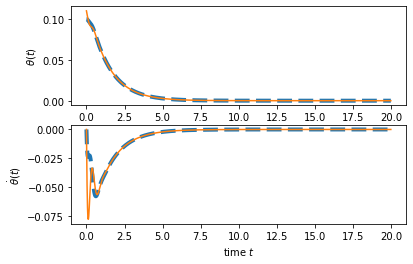

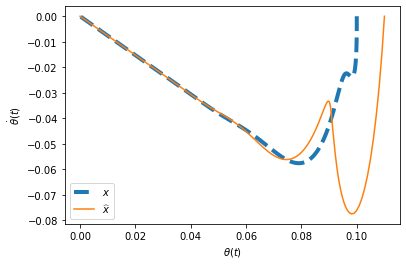

In [11]:
# define parameters
m = 1 # kg
ell = 1 # m
g = 9.81 # m/sec/sec
gamma = 1 

A = np.array([[0,1],[g/ell, -gamma/(m*ell**2)]])
B = np.array([[0],[1/(m*ell**2)]])
C = np.array([[ell, 0]])
D = np.array([[0]])
roots = [-5+8.66*1j, -5-8.66*1j] #Enter value
p = [-3. + np.sqrt(5),-3. - np.sqrt(5)]
K = place(A,B,p)

k1 = m*ell*g+4*m*ell**2
k2 = 4*m*ell**2 - gamma

L = place(A.T,C.T,roots).T

def f_NL(t,x,u):
  theta = x[0]
  dtheta = x[1]
  ddtheta = g/ell*np.sin(theta) - gamma/(m*(ell**2))*dtheta + u/(m*(ell**2))  # - k1/(m*(ell**2))*theta - k2/(m*(ell**2))*dtheta
  dx = np.array([dtheta, ddtheta])
  return dx

def h_NL(t,x,u):
  theta = x[0]
  dtheta = x[1]
  y = ell * np.sin(theta)
  return np.array([[y]])

def f_cl(t,z,u): 

  # extract controlled system and observer system state from full system state
  x,x_hat = z[:2],z[2:]
  # compute control input using observer state
  u = -np.dot(x_hat,K.T)
  
  # output from controlled system and observer system
  y = h_NL(t,x,u)
  y_hat = ell * x_hat[0] 
  
  
  # dynamics of controlled system and observer system
  dx = f_NL(t,x,u)
  #print(dx)
  dx_hat = np.dot(x_hat,A.T) + np.dot(u,B.T) + np.dot(y-y_hat,L.T)
  dx_hat = np.array(dx_hat)
  dx_hat = dx_hat[0]
  # combine dynamics of controlled system and observer system
  dz = np.hstack((np.squeeze(dx),np.squeeze(dx_hat)))
  return dz

# non-zero initial state
theta0 = 0.1
dtheta0 = 0.0
theta_hat0 = 0.11
dtheta_hat0 = 0.0
z0 = np.array([theta0, dtheta0, theta_hat0, dtheta_hat0])
T = 20
dt = 1e-2
# zero input
def u(t):
  ut = 0
  return ut

# numerical simulation returns:
# t_ - size N array
# z_ - size N x 2 array (since the state is 2-dimensional)
t_,z_ = numerical_simulation(f_cl,T,z0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
x_ = z_[:,:2]
x_hat_ = z_[:,2:]
theta_,dtheta_, = x_.T
theta_hat_,dtheta_hat_, = x_hat_.T

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt
plt.figure()

# plot theta, theta_hat
plt.subplot(2,1,1)
plt.plot(t_,theta_,'--',lw=4,label=r'$\theta$')
plt.plot(t_,theta_hat_,label=r'$\widehat{\theta}$')
plt.ylabel(r'$\theta(t)$')

# plot dtheta, dtheta_hat
plt.subplot(2,1,2)
plt.plot(t_,dtheta_,'--',lw=4,label=r'$\dot{\theta}$')
plt.plot(t_,dtheta_hat_,label=r'$\dot{\widehat{\theta}}$')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'time $t$')

plt.figure()
plt.subplot(1,1,1)
plt.plot(theta_,dtheta_,'--',lw=4,label=r'$x$')
plt.plot(theta_hat_,dtheta_hat_,label=r'$\widehat{x}$')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'${\theta}(t)$')
plt.legend();

b. Demonstrate that the controller in (a.) fails to stabilize the nonlinear system to the equilibrium by initializing the nonlinear system and/or linear observer sufficiently far from the equilibrium.

***Takeaway:*** we can apply linear systems tools to synthesize a controller that stabilizes a nonlinear system ***near an equilibrium***.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


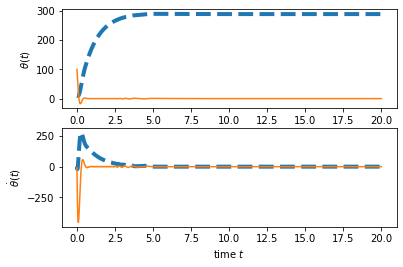

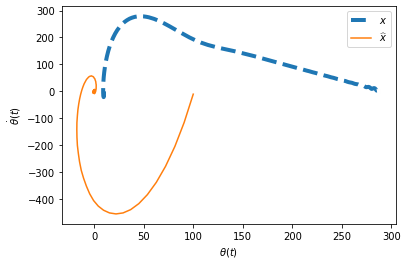

In [13]:
# non-zero initial state
theta0 = 10.
dtheta0 = 0.0
theta_hat0 = 100.11
dtheta_hat0 = -10.0
z0 = np.array([theta0, dtheta0, theta_hat0, dtheta_hat0])
T = 20
dt = 1e-2
# zero input
def u(t):
  ut = 0
  return ut

# numerical simulation returns:
# t_ - size N array
# z_ - size N x 2 array (since the state is 2-dimensional)
t_,z_ = numerical_simulation(f_cl,T,z0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
x_ = z_[:,:2]
x_hat_ = z_[:,2:]
theta_,dtheta_, = x_.T
theta_hat_,dtheta_hat_, = x_hat_.T

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt
plt.figure()

# plot theta, theta_hat
plt.subplot(2,1,1)
plt.plot(t_,theta_,'--',lw=4,label=r'$\theta$')
plt.plot(t_,theta_hat_,label=r'$\widehat{\theta}$')
plt.ylabel(r'$\theta(t)$')

# plot dtheta, dtheta_hat
plt.subplot(2,1,2)
plt.plot(t_,dtheta_,'--',lw=4,label=r'$\dot{\theta}$')
plt.plot(t_,dtheta_hat_,label=r'$\dot{\widehat{\theta}}$')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'time $t$')

plt.figure()
plt.subplot(1,1,1)
plt.plot(theta_,dtheta_,'--',lw=4,label=r'$x$')
plt.plot(theta_hat_,dtheta_hat_,label=r'$\widehat{x}$')
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'${\theta}(t)$')
plt.legend();

### * end of group work -- download as PDF and submit as part of group assignment *

## 0. [preferred name]; [preferred pronouns]

a. Approximately how many hours did you spend on this assignment?

b. Were there specific problems that took much longer than others?

c. What class meeting(s) did you participate in this week?

d. What timezone(s) were you working in this week?

## 1. transfer functions

Consider the model of a series RLC circuit from lecture,
$$ L \ddot{q} + R \dot{q} + q/C = v, $$
where $q$ denotes the charge on the capacitor,
($R$, $L$, $C$) denote the (resistor, inductor, capacitor) parameters,
and $v$ denotes a series voltage source.

***Purpose:*** practice determining transfer functions from state-space representations of LTI systems.

a. Determine the transfer function from input voltage to capacitor charge $G_{qv}(s)$.

**Solution:**

Laplace transform to obtain: $s^2Lq+sRq+\frac{q}{c}=v$

$$\fbox{$G_{qv}=\frac{q}{v}=\frac{1}{s^2L+sR+1/C}$}$$

---------------------------------------

b. With $x = (q,\dot{q})$ as the circuit's state, $u = v$ as the circuit's input, and $y = q$ as the circuit's output, determine matrices $A, B, C, D$ such that

$$ \dot{x} = A x + B u,\quad y = C x + D u. $$

**Solution:**

By determining that $\dot{x} = \left[\begin{matrix} \dot{q} \\ \ddot{q} \end{matrix}\right]=A\left[\begin{matrix} q\\ \dot{q} \end{matrix}\right] + Bv$ we can compare this against our equation for $\ddot{q}=\frac{v}{L}-\frac{R}{L}\dot{q}-\frac{q}{LC}$ to obtain:

 $\dot{x} = \left[\begin{matrix} \dot{q} \\ \ddot{q} \end{matrix}\right]=\left[\begin{matrix} 0 & 1 \\ \frac{-1}{LC} & \frac{-R}{L} \end{matrix}\right] \left[\begin{matrix} q\\ \dot{q} \end{matrix}\right] + \left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right]v$

 and similarly for $y=q=C\left[\begin{matrix} q\\ \dot{q} \end{matrix}\right]+Dv = \left[\begin{matrix} 1 & 0 \end{matrix}\right]+0v$

 $$\Leftrightarrow \fbox{$A=\left[\begin{matrix} 0 & 1 \\ \frac{-1}{LC} & \frac{-R}{L} \end{matrix}\right],
 B=\left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right],
 C=\left[\begin{matrix} 1 & 0 \end{matrix}\right],
 D=0 $}$$

 ----------------------------------------------------

c. Verify that the transfer function of the state-space system in (b.) is the same as the transfer function determined in (a.).  (***Hint:***  you just need to compute $C (sI - A)^{-1} B + D$ and verify that it equals $G_{qv}(s)$).

**Solution:**

$C (sI - A)^{-1} B + D = \left[\begin{matrix} 1 & 0 \end{matrix}\right](\left[\begin{matrix} s & 0 \\ 0 & s \end{matrix}\right]-\left[\begin{matrix} 0 & 1 \\ \frac{-1}{LC} & \frac{-R}{L} \end{matrix}\right])^{-1}\left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right]+0 = \left[\begin{matrix} 1 & 0 \end{matrix}\right](\left[\begin{matrix} s & -1 \\ \frac{1}{LC} & s+\frac{R}{L} \end{matrix}\right])^{-1}\left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right]$

Use your favorite computational tool to compute this inverse (I actually calculated by hand since for any $2\times 2$ matrix $M=\left[\begin{matrix} a & b \\ c & d \end{matrix}\right]^{-1}=\frac{1}{det(M)}\left[\begin{matrix} d & -b \\ -c & a \end{matrix}\right]$). Use this to determine that this matrix multiplication comes out to:

$C (sI - A)^{-1} B + D = \left[\begin{matrix} 1 & 0 \end{matrix}\right](\left[\begin{matrix} s & -1 \\ \frac{1}{LC} & s + \frac{R}{L} \end{matrix}\right])^{-1}\left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right]+0 
= \frac{1}{s^2 + \frac{R}{L}s + \frac{1}{LC}}(\left[\begin{matrix} 1 & 0 \end{matrix}\right](\left[\begin{matrix} s+\frac{R}{L} & 1 \\ \frac{-1}{LC} & s \end{matrix}\right])\left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right])
= \frac{1}{s^2 + \frac{R}{L}s + \frac{1}{LC}}(\left[\begin{matrix} s + \frac{R}{L} & 1 \end{matrix}\right]\left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right])$

$$\fbox{$G_{qv} = \frac{1}{s^2L+sR+1/C}$}$$

--------------------------------------------------

d. With $\widetilde{x} = (\frac{1}{2}(q + \dot{q}),\frac{1}{2}(q - \dot{q}))$ as the state, $u = v$ as the input, and $y = q$ as the output, determine matrices $\widetilde{A}, \widetilde{B}, \widetilde{C}, \widetilde{D}$ such that

$$ \dot{\widetilde{x}} = \widetilde{A} \widetilde{x} + \widetilde{B} u,\quad y = \widetilde{C} \widetilde{x} + \widetilde{D} u. $$

**Solution:**


 $$\widetilde{A}= TAT^{-1} , \widetilde{B} = TB$$
 
 We determine T using the relation $$ \widetilde{x} = Tx$$

  $$\left[\begin{matrix} \frac{1}{2}(q + \dot{q}) \\ \frac{1}{2}(q - \dot{q}) \end{matrix}\right] = \left[\begin{matrix} \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & \frac{-1}{2} \end{matrix}\right]\left[\begin{matrix} q \\ \dot{q} \end{matrix}\right]$$

Applying this to find $\widetilde{A}$ and $\widetilde{B}$ ,


 
 $$\widetilde{A} = \left[\begin{matrix} \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & \frac{-1}{2} \end{matrix}\right] \left[\begin{matrix} 0 & 1 \\ \frac{-1}{LC} & \frac{-R}{L} \end{matrix}\right] \left[\begin{matrix} 1 & 1 \\ 1 & -1 \end{matrix}\right]$$

 $$\Leftrightarrow \left[\begin{matrix} \frac{-(RC-LC+1)}{2LC} & \frac{RC-LC-1}{2LC} \\ \frac{RC+LC+1}{2LC} & \frac{-(RC+LC-1)}{2LC} \end{matrix}\right]$$

 $$\widetilde{B} = \left[\begin{matrix} \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & \frac{-1}{2} \end{matrix}\right] \left[\begin{matrix} 0 \\ \frac{1}{L} \end{matrix}\right] = \left[\begin{matrix} \frac{1}{2L} \\ \frac{-1}{2L} \end{matrix}\right]$$


 $$\Leftrightarrow \fbox{$\widetilde{A}=\left[\begin{matrix} \frac{-(RC-LC+1)}{2LC} & \frac{RC-LC-1}{2LC} \\ \frac{RC+LC+1}{2LC} & \frac{-(RC+LC-1)}{2LC} \end{matrix}\right], \widetilde{B}=\left[\begin{matrix} \frac{1}{2L} \\ \frac{-1}{2L} \end{matrix}\right]$}$$
 
$y=q=\widetilde{C}\left[\begin{matrix} \frac{1}{2}(q + \dot{q})\\ \frac{1}{2}(q - \dot{q}) \end{matrix}\right]+\widetilde{D}u = \left[\begin{matrix} 1 & 1 \end{matrix}\right]+0u$

$$\fbox{$\widetilde{C}=\left[\begin{matrix} 1 & 1 \end{matrix}\right],
 \widetilde{D}=0$}$$

 ----------------------------------

e. Verify that the transfer function of the state-space system in (d.) is the same as the transfer functions obtained in (a.), (c.).  (***Hint:***  you just need to compute $\widetilde{C} (sI - \widetilde{A})^{-1} \widetilde{B} + \widetilde{D}$ and verify that it equals $G_{qv}(s)$).

**Solution:**

 Transfer function for the state-space system is $\widetilde{C} (sI - \widetilde{A})^{-1} \widetilde{B} + \widetilde{D}$

 $$ \Leftrightarrow \left[\begin{matrix} 1 & 1 \end{matrix}\right] (\left[\begin{matrix} s & 0 \\ 0 & s \end{matrix}\right] - \left[\begin{matrix} \frac{-(RC-LC+1)}{2LC} & \frac{RC-LC-1}{2LC} \\ \frac{RC+LC+1}{2LC} & \frac{-(RC+LC-1)}{2LC} \end{matrix}\right])^{-1} \left[\begin{matrix} \frac{1}{2L} \\ \frac{-1}{2L} \end{matrix}\right]$$

  $$ \Leftrightarrow \left[\begin{matrix} 1 & 1 \end{matrix}\right] (\left[\begin{matrix} s + \frac{(RC-LC+1)}{2LC} & -\frac{RC-LC-1}{2LC} \\ -\frac{RC+LC+1}{2LC} & s + \frac{(RC+LC-1)}{2LC} \end{matrix}\right])^{-1} \left[\begin{matrix} \frac{1}{2L} \\ \frac{-1}{2L} \end{matrix}\right]$$

 $$\Leftrightarrow \left[\begin{matrix} 1 & 1 \end{matrix}\right]  \frac{1}{s^2 + (\frac{1}{2LC} - \frac{1}{2} + \frac{R}{2L} - \frac{1}{2LC} + \frac{1}{2} + \frac{R}{2L})s + ((\frac{1}{2LC} - \frac{1}{2} + \frac{R}{2L})(-\frac{1}{2LC} + \frac{1}{2} + \frac{R}{2L})) - ((\frac{1}{2LC} + \frac{1}{2} - \frac{R}{2L})(-\frac{1}{2LC} - \frac{1}{2} - \frac{R}{2L}))} \left[\begin{matrix} s - \frac{1-LC-RC}{2LC} & \frac{-1-LC+RC}{2LC} \\ \frac{1+LC+RC}{2LC} & s + \frac{1-LC+RC}{2LC} \end{matrix}\right] \left[\begin{matrix} \frac{1}{2L} \\ -\frac{1}{2L} \end{matrix}\right]$$

$$\Leftrightarrow \frac{1}{s^2 + \frac{R}{L}s + \frac{1}{LC}} \left[\begin{matrix} s + 1 + \frac{R}{L} & s - 1 + \frac{R}{L} \end{matrix}\right] \left[\begin{matrix} \frac{1}{2L} \\ -\frac{1}{2L} \end{matrix}\right]$$

$$\fbox{$G(s) = \frac{\frac{1}{L}}{s^2 + \frac{R}{L}s + \frac{1}{LC}}$}$$

This matches the transfer function we get for $G_{qv}$.

***Takeaway:*** the transfer function of a state-space system is the same regardless of what coordinates you choose for the state vector.  Thus, if we are primarily concerned with a system's input/output response (i.e. how input signal $u$ transforms to output signal $y$) and less concerned with the details of what happens "inside" the system (i.e. how the state $x$ is influenced by the input), the transfer function provides a convenient representation.

## 2. Bode plots

***Purpose:*** visualize and manipulate transfer functions and their interconnections using ***Bode plots***, that is, plots that show how sinusoidal inputs are amplified/attenuated and phase-shifted by a transfer function $G$ as a function of the input frequency $\omega$.

Consider the transfer function process model for an RC circuit with a voltage source as the input and capacitor voltage as the output,

$$ P(s) = \frac{1}{1 + s RC}. $$

Use parameter values $R = 1$M$\Omega$, $C = 1\mu$F (i.e. $R C = 1$) in the remainder of the problem.

a. Create the ***Bode plot*** for $P$, that is, plot $| P(j\omega) |$ and $\angle P(j\omega)$ versus $\omega$.  (***Hint:*** refer to the RLC Circuit example in Section 2 of the [lecture examples notebook](https://colab.research.google.com/github/sburden/447/blob/master/447_lec_examples.ipynb) for plotting code; you should use the ``plt.subplot``, ``plt.loglog``, and ``plt.semilogx`` functions in your solution.)

If we instead consider the transfer function from the input voltage to the resistor voltage, we obtain the transfer function

$$ Q(s) = \frac{s RC}{1 + sRC}. $$

b. Create the Bode plot for $Q$.

c. Create the Bode plot for the numerator $N(s) = s RC$ of $Q$.

d. Noting that $Q(s) = P(s) N(s)$, determine how the Bode plot of $Q$ is related to the Bode plots of $P$ and $N$.  (***Note:*** the magnitude component of the Bode plot should be represented logarithmically.)

e. Verify the relationship you derived in (d.) by overlaying the Bode plot of $P(s)N(s)$ on your Bode plot of $Q$ from (b.).

f. Describe the Bode plots of $N$, $Q$, and $P$ as ***filters***, that is, explain how each system responds to "low frequency" inputs (specify a range of frequencies you regard as "low") and "high frequency" inputs (specify a range of frequencies you regard as "high").  Could you predict the combined response of $Q = P N$  based on the individual responses of $N$ and $P$?

***Takeaway:*** Bode plots provide a convenient visualization of a transfer function that enables us to determine how systems respond to input frequency components, individually and through interconnection.

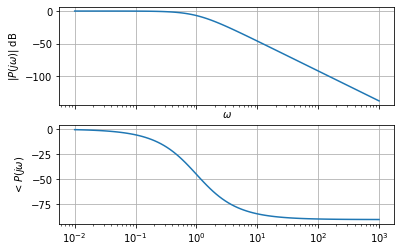

In [33]:
# solutions for part a
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

# calculate transfer function
P = lambda s: (1)/(1.+0j+s)
omega = np.logspace(-2,3,100) # goes from 1e-2 to 1e3 
s = 1j*omega
y = P(s)
mag = 20*np.log(np.abs(y)) # get magnitude in decibels (dB)
phase = np.angle(y)*180./np.pi # get phase in degrees

fig,ax = plt.subplots(2,1,sharex=True)

# plot magnitude
ax[0].semilogx(omega, mag)
ax[0].set_ylabel(r'$|P(j\omega)|$ dB')
ax[0].set_xlabel(r'$\omega$')
ax[0].grid()

# plot phase
ax[1].semilogx(omega, phase)
ax[1].set_ylabel(r'$<P(j\omega)$')
ax[0].set_xlabel(r'$\omega$')
ax[1].grid()

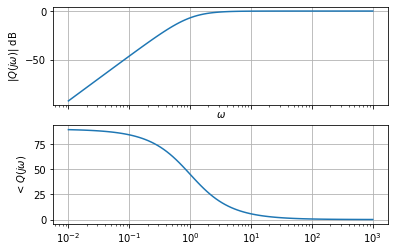

In [34]:
# solutions for part b

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

Q = lambda s: (s)/(1.+0j+s)
omega = np.logspace(-2,3,100) # goes from 1e-2 to 1e3 
s = 1j*omega
y = Q(s)
mag = 20*np.log(np.abs(y))
phase = np.angle(y)*180./np.pi

fig,ax = plt.subplots(2,1,sharex=True)

# plot magnitude
ax[0].semilogx(omega, mag)
ax[0].set_ylabel(r'$|Q(j\omega)|$ dB')
ax[0].set_xlabel(r'$\omega$')
ax[0].grid()

# plot phase
ax[1].semilogx(omega, phase)
ax[1].set_ylabel(r'$<Q(j\omega)$')
ax[0].set_xlabel(r'$\omega$')
ax[1].grid()

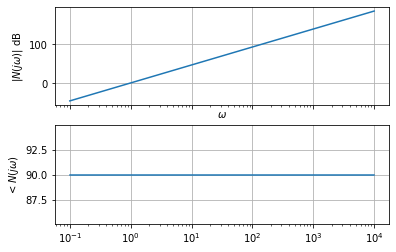

In [35]:
# code for part c
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

omega = np.logspace(-1,4,100) # goes from 1e-1 to 1e4 
s = 1j*omega
mag = 20*np.log(np.abs(s))
phase = np.angle(s)*180./np.pi

fig,ax = plt.subplots(2,1,sharex=True)

# plot magnitude
ax[0].semilogx(omega, mag)
ax[0].set_ylabel(r'$|N(j\omega)|$ dB')
ax[0].set_xlabel(r'$\omega$')
ax[0].grid()

# plot phase
ax[1].semilogx(omega, phase)
ax[1].set_ylabel(r'$<N(j\omega)$')
ax[0].set_xlabel(r'$\omega$')
ax[1].grid()

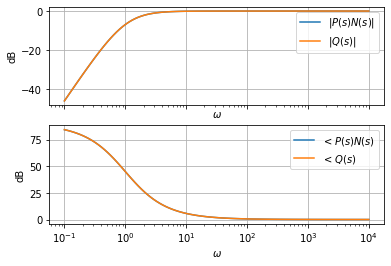

In [40]:
# part c solution
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

P = lambda s: (1.+0j)/(1.+0j+s)
N = lambda s: (s)
Q = lambda s: (s)/(1.+0j+s)
omega = np.logspace(-1,4,100) # goes from 1e-1 to 1e4 
s = 1j*omega

y1 = P(s)*N(s)
mag1 = 20*np.log(np.abs(y1))
phase1 = np.angle(y1)*180./np.pi

y2 = Q(s)
mag2 = 20*np.log(np.abs(y2))
phase2 = np.angle(y2)*180./np.pi

fig,ax = plt.subplots(2,1,sharex=True)

# plot magnitude
ax[0].semilogx(omega, mag1)
ax[0].semilogx(omega, mag2)
ax[0].set_ylabel(r'dB')
ax[0].set_xlabel(r'$\omega$')
ax[0].legend([r'$|P(s)N(s)|$', r'$|Q(s)|$'])
ax[0].grid()

# plot phase
ax[1].semilogx(omega, phase1)
ax[1].semilogx(omega, phase2)
ax[1].set_ylabel(r'dB')
ax[1].set_xlabel(r'$\omega$')
ax[1].legend([r'$<P(s)N(s)$', r'$<Q(s)$'])
ax[1].grid() 

# matches bode plot for q

** SOLUTION TO PART (f) **

$P(s)$ passes low frequencies and attenuates high frequencies, so it is a low-pass filter. $N(s)$ is a differentiator (the differential operator), it has a constant phase of 90 degrees, and it amplifies high frequencies while attenuating low frequencies. $Q(s)$ is the series combination of $P(s)$ and $N(s)$, it attenuates low frequencies, and passes high frequencies, so it is a high-pass filter.